The initial file with twitts is required.

In this notebook we will clean gathered twitts in the end we will perform sentiment analysis with Vader library, just as an example.  

In [2]:
# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import codecs

import re
from bs4 import BeautifulSoup
from textblob import TextBlob
from datetime import datetime, timedelta

In [3]:
# deleting unnesessary simbols
def unicodetoascii(text):

    TEXT = (text.
    		replace('\\xe2\\x80\\x99', "'").
            replace('\\xc3\\xa9', 'e').
            replace('\\xe2\\x80\\x90', '-').
            replace('\\xe2\\x80\\x91', '-').
            replace('\\xe2\\x80\\x92', '-').
            replace('\\xe2\\x80\\x93', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x94', '-').
            replace('\\xe2\\x80\\x98', "'").
            replace('\\xe2\\x80\\x9b', "'").
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9c', '"').
            replace('\\xe2\\x80\\x9d', '"').
            replace('\\xe2\\x80\\x9e', '"').
            replace('\\xe2\\x80\\x9f', '"').
            replace('\\xe2\\x80\\xa6', '...').#
            replace('\\xe2\\x80\\xb2', "'").
            replace('\\xe2\\x80\\xb3', "'").
            replace('\\xe2\\x80\\xb4', "'").
            replace('\\xe2\\x80\\xb5', "'").
            replace('\\xe2\\x80\\xb6', "'").
            replace('\\xe2\\x80\\xb7', "'").
            replace('\\xe2\\x81\\xba', "+").
            replace('\\xe2\\x81\\xbb', "-").
            replace('\\xe2\\x81\\xbc', "=").
            replace('\\xe2\\x81\\xbd', "(").
            replace('\\xe2\\x81\\xbe', ")")

                 )
    return TEXT


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loading the data. 

In [ ]:
cols = ["Date and time","Text","red"]

# gathered tweets from tweeter_madness 
# tweets with hashtag #bitcoin
df = pd.read_csv("bit_coi.csv", header=None, names=cols)


# length of the tweets 
df['pre_clean_len'] = [len(t) for t in df.Text]
# let's extract hashtags 
df['hash_tag'] = [re.findall(r"#(\w+)", t) for t in df.Text]



## Cleaning tweets 

On this picture below we can see, that length of some tweets are more than 140.
So, cleaning is nessesary. 

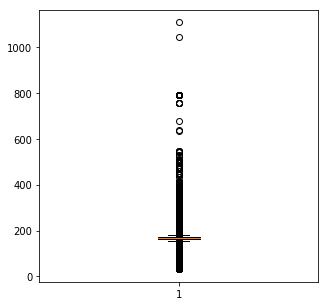

In [4]:
 fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

Deleting all unnesessary stuff from twitts. 

In [5]:
clean_text = []
author = []
for t in df.Text:
    t = BeautifulSoup(t, 'lxml').get_text()
    author.append(re.findall(r'@[A-Za-z0-9]+',t))
    t = re.sub(r'@[A-Za-z0-9]+','',t)
    t = t.strip('\n, b\' RT :')
    t = t.strip(r'RT')
    t = re.sub('[A-za-z0-9]:','',t)
    t = re.sub(r'http//[A-Za-z0-9./]+','',t)
    t = re.sub(r'\\x[A-za-z0-9][A-za-z0-9]','',t)
    t = re.sub(r'\\n','',t)
    t = unicodetoascii(t)
    clean_text.append(t)
    
    
remove_punctuaton = '!"$%&\'()*+,-./:;<=>?@[\\]“”^_`{|}~'
set_listset_list = []
clean_tweet_list = []
set_list = []
translator = str.maketrans('', '', remove_punctuaton) #very fast punctuation remover!
for word in clean_text:
    list_form = word.split() #turns the word into a list
    
    to_process = [x for x in list_form if not x.startswith("@")] #removes handles
    
    to_process_2 = [x for x in to_process if not x.startswith("RT")] #removed retweet indicator
    
    string_form = " ".join(to_process_2) #back into a string
    
    set_form = set(string_form.translate(translator).strip().lower().split()) #this is the magic!
    
    clean_tweet_list.append(string_form.translate(translator).strip().lower())
    
    set_list.append(tuple(set_form)) #need to make it a tuple so it's hashable!

In [6]:
new_list = []
for _ in range(len(df['Date and time'])):
    new_list.append([df['Date and time'][_],clean_tweet_list[_],set_list[_], df.hash_tag[_],author[_]])
cols = ["date_time","text","core text", 'hash_tag','author']
df_clean = pd.DataFrame.from_records(new_list, columns = cols)
# Length of tweets
df_clean['pre_clean_len'] = [len(t) for t in df_clean["text"]]

Let's examine our twitts now. 

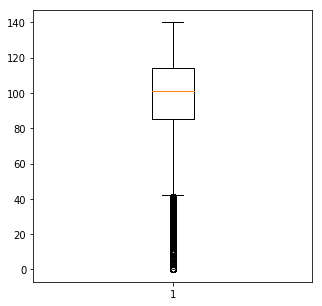

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_clean.pre_clean_len)
plt.show()

We can see that the length is normal now. However we cleaned only the simple garbage. 
Some irrelevant stuff is still there. However is is left for the future research. 

## Vader sentiment analisys

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    #note: depending on how you installed (e.g., using source code download versus pip install), you may need to import like this:
    #from vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
compound = []
neg = []
neu = []
pos = []
for sentence in df_clean.text:
    vs = analyzer.polarity_scores(sentence)
    compound.append(vs['compound'])
    neg.append(vs['neg'])
    neu.append(vs['neu'])
    pos.append(vs['pos'])
df_clean['compound'] = compound
df_clean['neg'] = neg
df_clean['neu'] = neu
df_clean['pos'] = pos

df_clean.to_csv('bit_coin_clean.csv')
